<a href="https://colab.research.google.com/github/cemredogan-ceng/BUSI/blob/main/busi_alexnet_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install necessary libraries
!pip install segmentation-models-pytorch torch torchvision scikit-learn

# Import Libraries
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image, ImageEnhance
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Mount Google Drive
drive.mount('/content/drive')

# Dataset directory
base_dir = '/content/drive/My Drive/Dataset_BUSI_with_GT'

# Custom Dataset Class
class BreastUltrasoundDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale mask

        # Apply data augmentations
        if np.random.rand() > 0.5:
            image = ImageEnhance.Contrast(image).enhance(1.5)
        if np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        if np.random.rand() > 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Load image and mask paths
image_paths, mask_paths = [], []
for cls in ['benign', 'malignant']:
    class_dir = os.path.join(base_dir, cls)
    for filename in os.listdir(class_dir):
        if filename.endswith(".png") and "_mask" not in filename:
            image_paths.append(os.path.join(class_dir, filename))
            mask_paths.append(os.path.join(class_dir, filename.replace(".png", "_mask.png")))

# Split dataset into training, validation, and test sets
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Transformations
transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Datasets and DataLoaders
train_dataset = BreastUltrasoundDataset(train_images, train_masks, transform_image, transform_mask)
val_dataset = BreastUltrasoundDataset(val_images, val_masks, transform_image, transform_mask)
test_dataset = BreastUltrasoundDataset(test_images, test_masks, transform_image, transform_mask)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define AlexNet-based segmentation model
class AlexNetSegmentationModel(nn.Module):
    def __init__(self, weights=AlexNet_Weights.IMAGENET1K_V1, num_classes=1):
        super(AlexNetSegmentationModel, self).__init__()
        self.encoder = alexnet(weights=weights)
        self.encoder.classifier = nn.Identity()  # Remove classification head

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),
            nn.Conv2d(32, num_classes, kernel_size=1),
        )

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        features = self.encoder.features(x)
        decoded = self.decoder(features)
        decoded = F.interpolate(decoded, size=(256, 256), mode="bilinear", align_corners=True)
        return decoded

# Initialize model
model = AlexNetSegmentationModel(weights=AlexNet_Weights.DEFAULT, num_classes=1).cuda()

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

loss_function = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        predictions = model(images)
        loss = loss_function(predictions, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            predictions = model(images)
            loss = loss_function(predictions, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

# Save model
torch.save(model.state_dict(), '/content/drive/My Drive/Dataset_BUSI_with_GT/alexnet_focal_loss_model.pth')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20, Training Loss: 0.0932, Validation Loss: 0.0775
Epoch 2/20, Training Loss: 0.0689, Validation Loss: 0.0614
Epoch 3/20, Training Loss: 0.0550, Validation Loss: 0.0570
Epoch 4/20, Training Loss: 0.0487, Validation Loss: 0.0542
Epoch 5/20, Training Loss: 0.0468, Validation Loss: 0.0598
Epoch 6/20, Training Loss: 0.0457, Validation Loss: 0.0467
Epoch 7/20, Training Loss: 0.0407, Validation Loss: 0.0486
Epoch 8/20, Training Loss: 0.0396, Validation Loss: 0.0468
Epoch 9/20, Training Loss: 0.0384, Validation Loss: 0.0437
Epoch 10/20, Training Loss: 0.0367, Validation Loss: 0.0457
Epoch 11/20, Training Loss: 0.0360, Validation Loss: 0.0426
Epoch 12/20, Training Loss: 0.0343, Validation Loss: 0.0453
Epoch 13/20, Training Loss: 0.0346, Validation Loss: 0.0439
Epoch 14/20, Training Loss: 0.0333, Validation Loss: 0.0401
Epoch 15/20, Training Loss: 0.0328, Vali

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(test_loader, model):
    model.eval()
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.cuda()
            masks = masks.cuda()

            # Get model predictions
            predictions = model(images)
            predictions = torch.sigmoid(predictions).cpu().numpy()  # Apply sigmoid to get probabilities
            masks = masks.cpu().numpy()

            # Binarize predictions and masks
            predictions_binary = (predictions > 0.5).astype(np.uint8)  # Threshold at 0.5
            masks_binary = (masks > 0.5).astype(np.uint8)  # Threshold for masks as well

            # Flatten predictions and masks for metric calculation
            all_preds.append(predictions_binary.flatten())
            all_masks.append(masks_binary.flatten())

    # Concatenate all predictions and ground truth
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_masks)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    # Dice score
    intersection = np.logical_and(y_true, y_pred).sum()
    dice_score = (2 * intersection) / (y_true.sum() + y_pred.sum() + 1e-6)

    # IoU (Jaccard Index)
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / (union + 1e-6)

    # Print metrics
    print("Evaluation Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Dice Score: {dice_score:.4f}")
    print(f"  IoU (Jaccard Index): {iou:.4f}")

# Evaluate the model on the test set
evaluate_model(test_loader, model)


Evaluation Metrics:
  Accuracy: 0.9511
  Precision: 0.7536
  Recall: 0.5824
  F1 Score: 0.6570
  Dice Score: 0.6570
  IoU (Jaccard Index): 0.4892


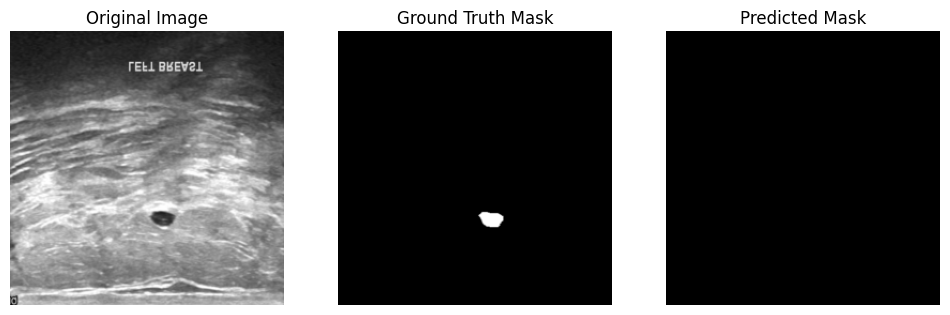

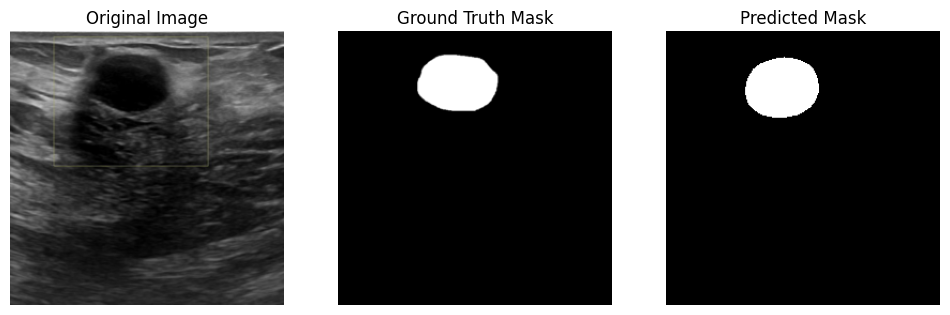

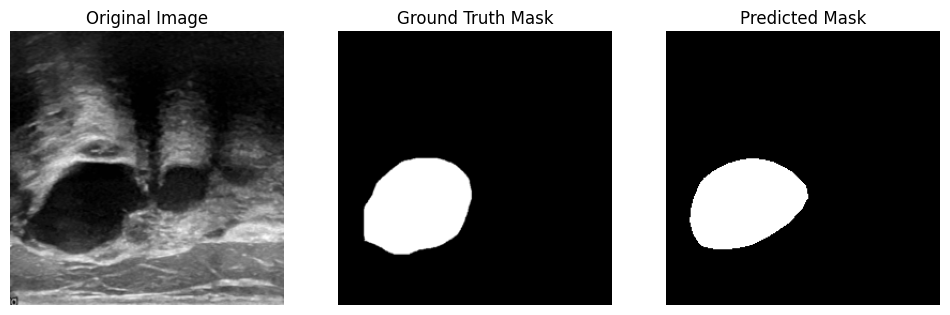

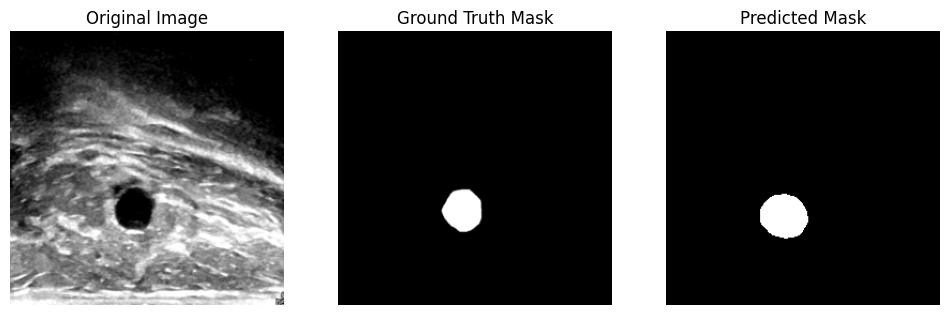

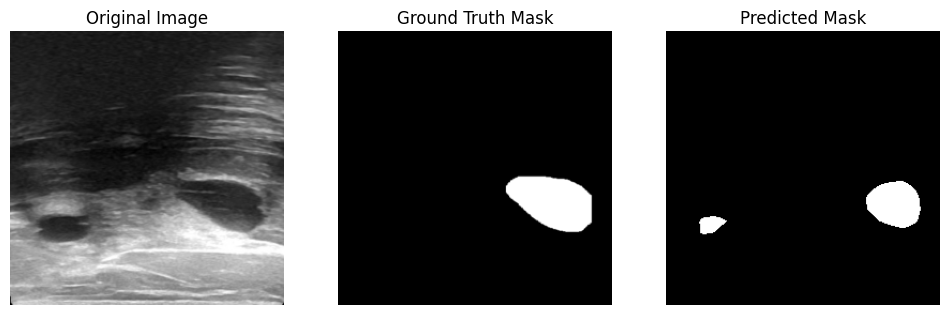

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(dataset, model, num_samples=5):
    """
    Visualize original images, ground truth masks, and predicted masks.

    Args:
    - dataset: Dataset object containing images and masks.
    - model: Trained segmentation model.
    - num_samples: Number of samples to visualize.
    """
    model.eval()  # Set model to evaluation mode

    for i in range(num_samples):
        image, mask = dataset[i]  # Get an image and its ground truth mask
        image_input = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU

        with torch.no_grad():
            # Get model prediction
            prediction = model(image_input)
            prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()  # Sigmoid and move to CPU
            prediction_binary = (prediction > 0.5).astype(np.uint8)  # Binarize prediction

        # Plot original image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC for plotting
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze().numpy(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()
# Modelin tahminlerini görselleştir
visualize_predictions(dataset, model, num_samples=5)

